## Mean field theory
* https://nest-simulator.readthedocs.io/en/latest/auto_examples/brunel_siegert_nest.html

* This script performs a mean-field analysis of the spiking network of excitatory and an inhibitory population of leaky-integrate-and-fire neurons simulated in brunel_delta_nest.py. We refer to this spiking network of LIF neurons with ‘SLIFN’.

* The self-consistent equation for the population-averaged firing rates (eq.27 in [1], [2]) is solved by integrating a pseudo-time dynamics (eq.30 in [1]). The latter constitutes a network of rate neurons, which is simulated here. The asymptotic rates, i.e., the fixed points of the dynamics (eq.30), are the prediction for the population and time-averaged from the spiking simulation.


### References
[1] Hahne J, Dahmen D, Schuecker J, Frommer A, Bolten M, Helias M and Diesmann M. (2017). Integration of continuous-time dynamics in a spiking neural network simulator. Front. Neuroinform. 11:34. doi: 10.3389/fninf.2017.00034

[2] Schuecker J, Schmidt M, van Albada SJ, Diesmann M. and Helias, M. (2017). Fundamental activity constraints lead to specific interpretations of the connectome. PLOS Computational Biology 13(2): e1005179. https://doi.org/10.1371/journal.pcbi.1005179

In [1]:
import nest
import numpy

nest.ResetKernel()

[admin:1459654] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.admin.1000/jf.0/3332046848/shared_mem_cuda_pool.admin could be created.
[admin:1459654] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Oct  2 2024 11:54:50

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
dt = 0.1  # the resolution in ms
simtime = 1000.0  # Simulation time in ms

In [3]:
g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

In [4]:
order = 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)  # total number of synapses per neuron

In [5]:
tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
neuron_params = {
    "tau_m": tauMem,
    "t_ref": 2.0,
    "theta": theta,
    "V_reset": 0.0,
}

J = 0.1  # postsynaptic amplitude in mV in the SLIFN
J_ex = J  # amplitude of excitatory postsynaptic potential
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential
# drift_factor in diffusion connections (see [1], eq. 28) for external
# drive, excitatory and inhibitory neurons
drift_factor_ext = tauMem * 1e-3 * J_ex
drift_factor_ex = tauMem * 1e-3 * CE * J_ex
drift_factor_in = tauMem * 1e-3 * CI * J_in
# diffusion_factor for diffusion connections (see [1], eq. 29)
diffusion_factor_ext = tauMem * 1e-3 * J_ex**2
diffusion_factor_ex = tauMem * 1e-3 * CE * J_ex**2
diffusion_factor_in = tauMem * 1e-3 * CI * J_in**2

In [6]:
nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

In [7]:
nest.resolution = dt
nest.print_time = True
nest.overwrite_files = True
nest.local_num_threads = 30
print("Building network")


Oct 03 06:14:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Building network


In [8]:
siegert_ex = nest.Create("siegert_neuron", params=neuron_params)
siegert_in = nest.Create("siegert_neuron", params=neuron_params)

In [9]:
# The Poisson drive in the SLIFN is replaced by a driving rate neuron, 
# which does not receive input from other neurons. 
# The activity of the rate neuron is controlled by setting mean to the rate 
# of the corresponding poisson generator in the SLIFN.
siegert_drive = nest.Create("siegert_neuron", params={"mean": p_rate})

In [10]:
multimeter = nest.Create("multimeter", params={"record_from": ["rate"], "interval": dt})

In [11]:
syn_dict = {
    "drift_factor": drift_factor_ext,
    "diffusion_factor": diffusion_factor_ext,
    "synapse_model": "diffusion_connection",
}

nest.Connect(siegert_drive, siegert_ex + siegert_in, "all_to_all", syn_dict)
nest.Connect(multimeter, siegert_ex + siegert_in)

In [12]:
syn_dict = {
    "drift_factor": drift_factor_ex,
    "diffusion_factor": diffusion_factor_ex,
    "synapse_model": "diffusion_connection",
}
nest.Connect(siegert_ex, siegert_ex + siegert_in, "all_to_all", syn_dict)

In [13]:
syn_dict = {
    "drift_factor": drift_factor_in,
    "diffusion_factor": diffusion_factor_in,
    "synapse_model": "diffusion_connection",
}
nest.Connect(siegert_in, siegert_ex + siegert_in, "all_to_all", syn_dict)

In [14]:
nest.Simulate(simtime)


Oct 03 06:14:11 NodeManager::prepare_nodes [Info]: 
    Preparing 33 nodes for simulation. 3 of them use iterative solution 
    techniques.

Oct 03 06:14:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 33
    Simulation time (ms): 1000
    Number of OpenMP threads: 30
    Number of MPI processes: 1

[  66% ] Model time: 658.0 ms, Real-time factor: 0.1279ime: 426.0 ms, Real-time factor: 0.1289

In [15]:
data = multimeter.events
rates_ex = data["rate"][numpy.where(data["senders"] == siegert_ex.global_id)]
rates_in = data["rate"][numpy.where(data["senders"] == siegert_in.global_id)]
times = data["times"][numpy.where(data["senders"] == siegert_in.global_id)]
print(f"Excitatory rate   : {rates_ex[-1]:.2f} Hz")
print(f"Inhibitory rate   : {rates_in[-1]:.2f} Hz")

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.1276

Oct 03 06:14:11 SimulationManager::run [Info]: 
    Simulation finished.


Excitatory rate   : 32.03 Hz
Inhibitory rate   : 32.03 Hz


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

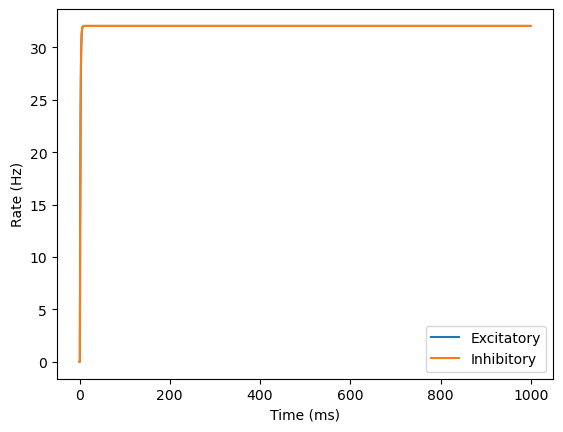

In [17]:
plt.plot(times, rates_ex, label="Excitatory")
plt.plot(times, rates_in, label="Inhibitory")
plt.xlabel("Time (ms)")
plt.ylabel("Rate (Hz)")
plt.legend()